In [1]:
from IPython.core.interactiveshell import InteractiveShell 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import norm
import os

In [2]:
nb_path = os.path.abspath(".")
InteractiveShell.ast_node_interactivity = "all"
sns.set(color_codes=True)

# Exploratory Data Analysis

## Variable Identification and Basic Analysis
- **Target Varaible** : Binar OP130_Resultat_Global_v
- **Dataset Size** : train : 34515 rows × 15 columns, test : 8001 rows × 14 columns
- **Data Types** : float64 :    13, int64 :       1, object :      1
- **Missing Values** : OP100_Capuchon_insertion_mesure is missing 53,9%
- **Variable signification**: 
    - OP070_V1: Twisting Operation
    - OP070_V2: Twisting Operation
    - OP090: SnapRing related Operation
    - OP100: Capuchon Insertion
    - OP110: Vissage
    - OP120: Rodage
    
## Univariate Analysis
- **Visualisation of the Target** : 0 : 99.1% , 1 : 0.9%
    
    
- **Visualisation of Variables** : not all normally distributed , not standardized, some variables are skewed, others are discrete.
   

## Bivariate Analysis

- **Variables / Target Relation** : no apparent difference in distribution betweeen "KO" and "OK" labeled variables.
   

- **Variables / Variables Relation** : variables from the same machine tend have a higher correlation degree
    

## Hypothesis Tests 

## ideas bucket
- engineer PROC_TRACEINFO to datetime column
- plot variables in the chronological order
    

## Variable Identification and Basic Analysis

In [28]:
trainset

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar OP130_Resultat_Global_v
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,0
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,0
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,0
3,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,0
4,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34510,I-B-XA1207672-190520-00031,158.2,168.40,180.6,110.65,11.88,12.23,NaN,11.98,6.61,24.03,14.8,98.76,6.61,0
34511,I-B-XA1207672-190906-00270,139.4,146.24,154.5,108.14,12.04,12.27,0.41,11.97,6.41,21.52,15.5,98.37,6.40,0
34512,I-B-XA1207672-190429-00930,165.5,157.34,149.8,112.77,12.09,12.17,NaN,11.97,6.62,22.65,24.4,92.92,6.62,0
34513,I-B-XA1207672-190424-02120,152.4,165.07,140.0,111.19,12.06,12.34,NaN,11.97,6.60,20.77,13.6,101.21,6.60,0


In [3]:
testset = pd.read_csv(os.path.join(nb_path,"testinputs.csv"))
trainset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [4]:
target = "Binar OP130_Resultat_Global_v"

In [5]:
trainset.describe()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar OP130_Resultat_Global_v
count,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,15888.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000
mean,159.906922,156.915055,159.618236,113.350222,11.970190,12.256785,0.388173,11.971027,6.548403,23.630152,17.878398,97.700978,6.550867,0.008837
std,15.662650,11.271492,15.091490,3.528522,0.169873,0.065319,0.024425,0.003050,0.097602,2.546341,6.785079,6.837714,0.094814,0.093589
min,101.800000,0.000000,82.000000,99.990000,0.000000,12.030000,0.240000,11.970000,5.670000,0.000000,6.300000,0.000000,5.740000,0.000000
25%,148.700000,149.210000,149.400000,111.040000,11.850000,12.210000,0.380000,11.970000,6.410000,22.280000,13.500000,94.310000,6.420000,0.000000
50%,158.000000,156.180000,158.700000,113.160000,12.040000,12.260000,0.390000,11.970000,6.610000,23.880000,16.400000,98.500000,6.610000,0.000000
75%,169.300000,164.380000,168.900000,115.380000,12.080000,12.300000,0.410000,11.970000,6.620000,25.290000,20.200000,102.230000,6.610000,0.000000
max,198.300000,196.920000,198.100000,177.950000,12.190000,12.500000,0.420000,11.990000,6.670000,43.410000,84.600000,127.300000,6.670000,1.000000


In [6]:
trainset.shape

(34515, 15)

In [7]:
testset.shape

(8001, 14)

In [8]:
trainset.dtypes.value_counts()

float64    13
int64       1
object      1
dtype: int64

<AxesSubplot:>

<AxesSubplot:>

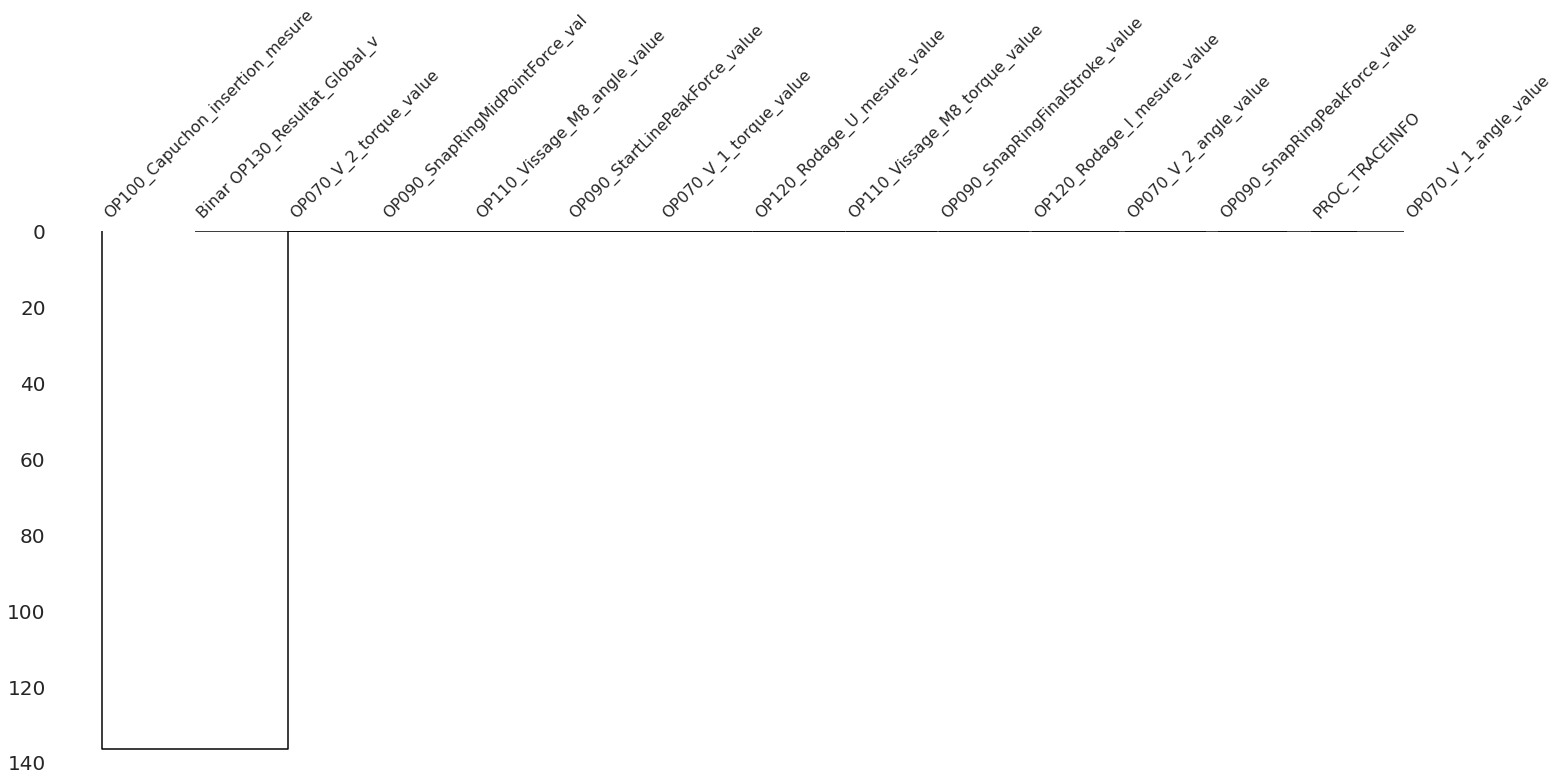

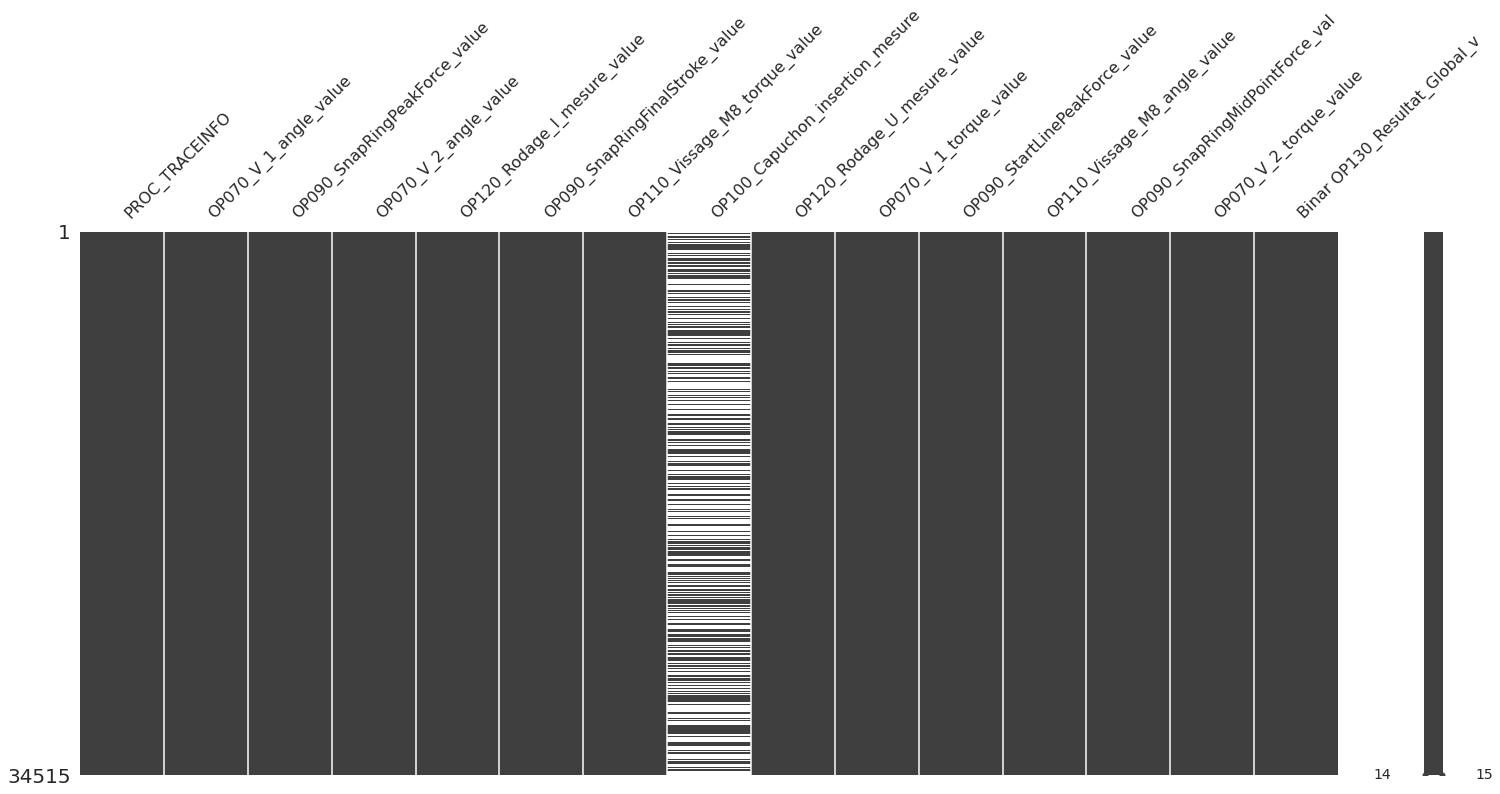

In [9]:
msno.dendrogram(trainset)
msno.matrix(trainset)

In [10]:
trainset['OP100_Capuchon_insertion_mesure'].isna().value_counts(normalize=True)

True     0.539678
False    0.460322
Name: OP100_Capuchon_insertion_mesure, dtype: float64

## Univariate Analysis

### Visualisation of the Target

In [11]:
trainset["Binar OP130_Resultat_Global_v"].value_counts(normalize=True)

0    0.991163
1    0.008837
Name: Binar OP130_Resultat_Global_v, dtype: float64

### Visualisation of Variables

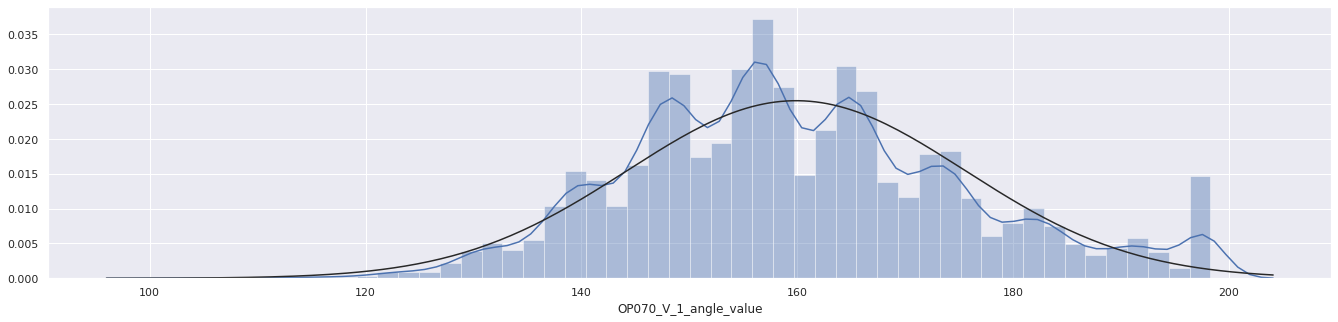

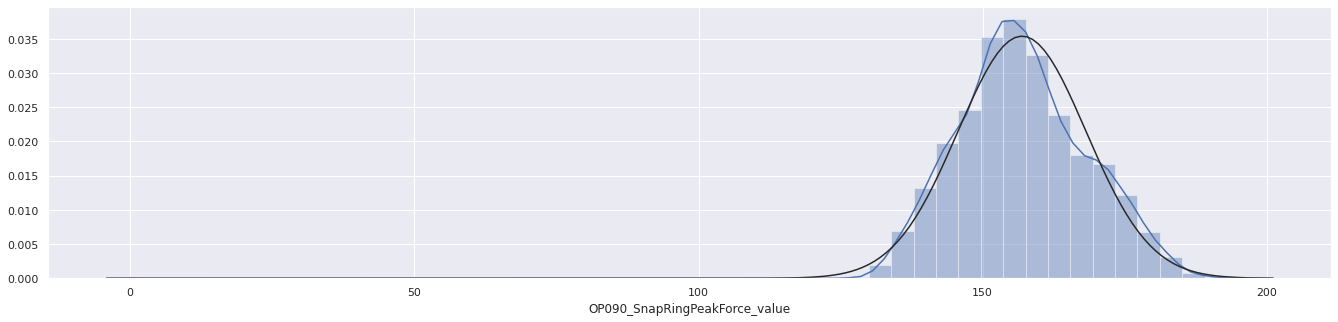

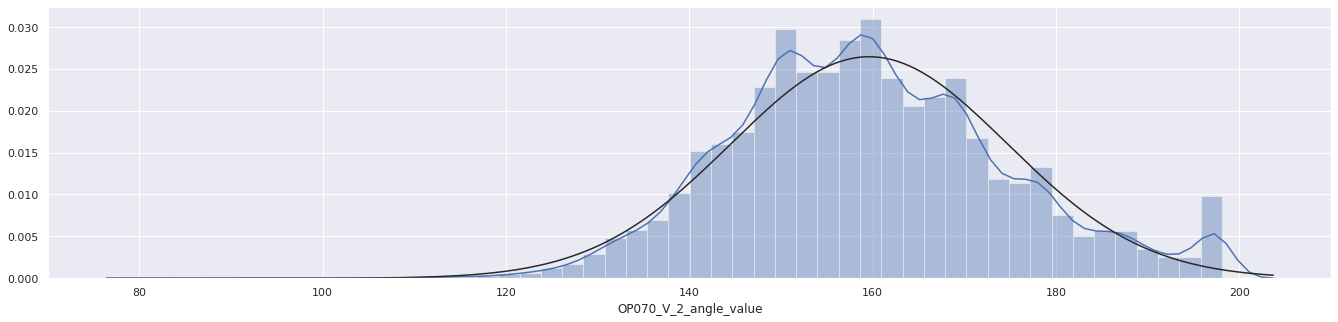

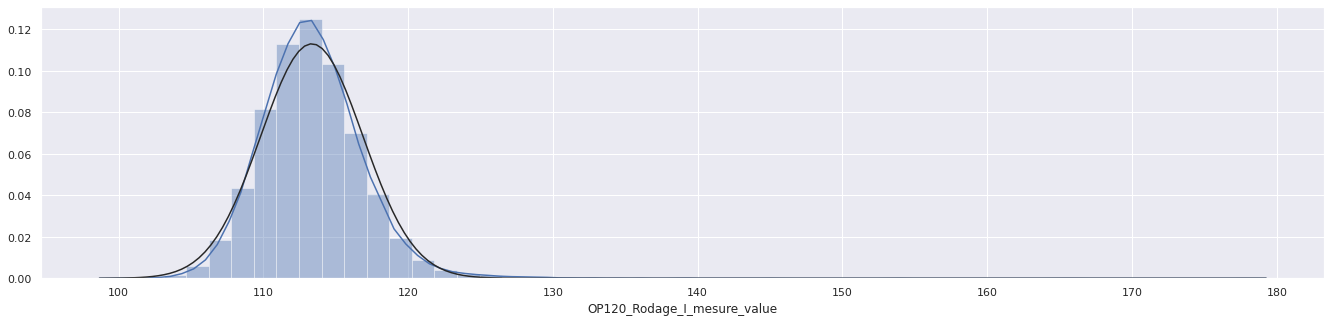

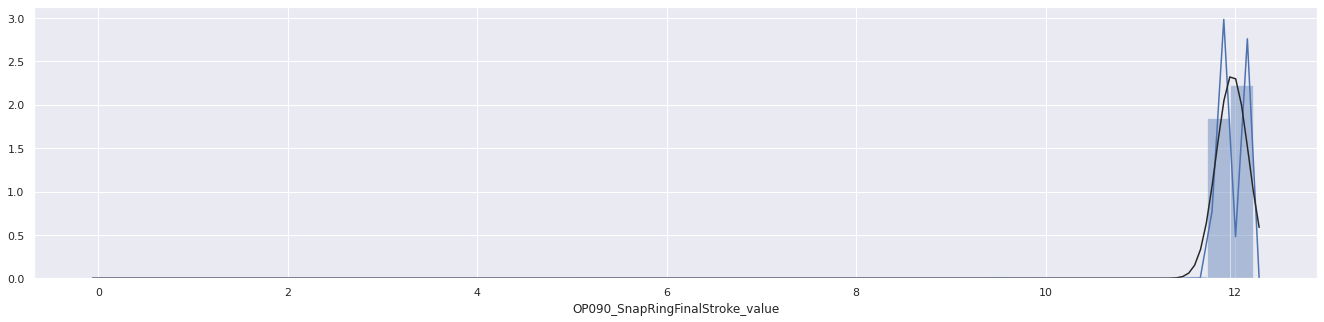

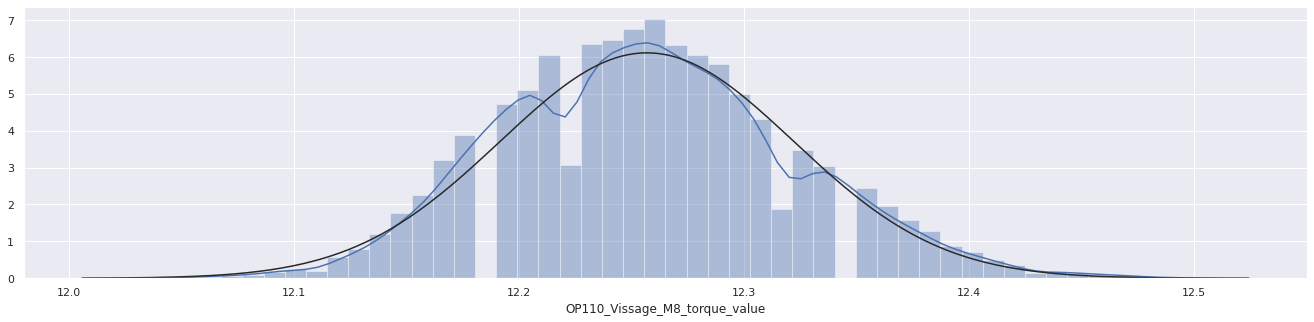

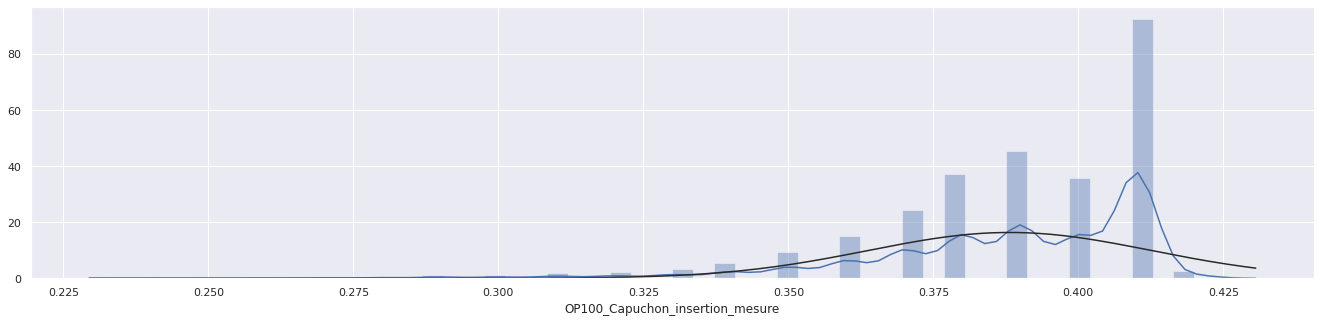

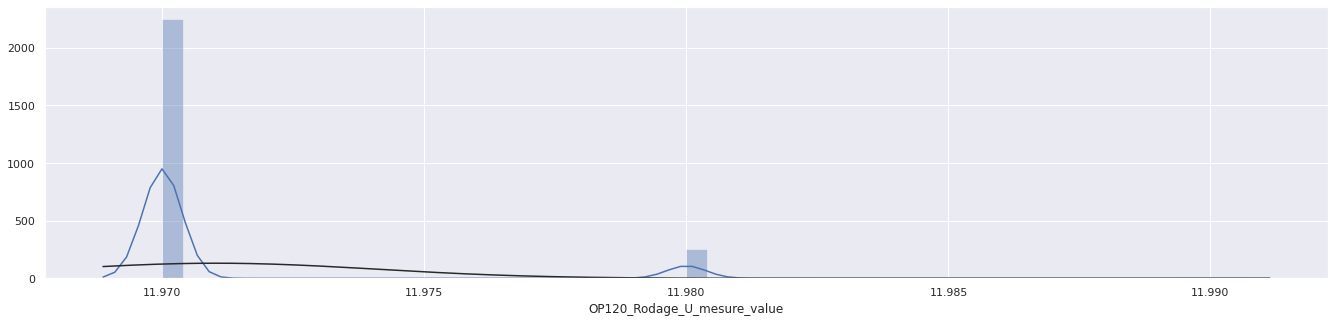

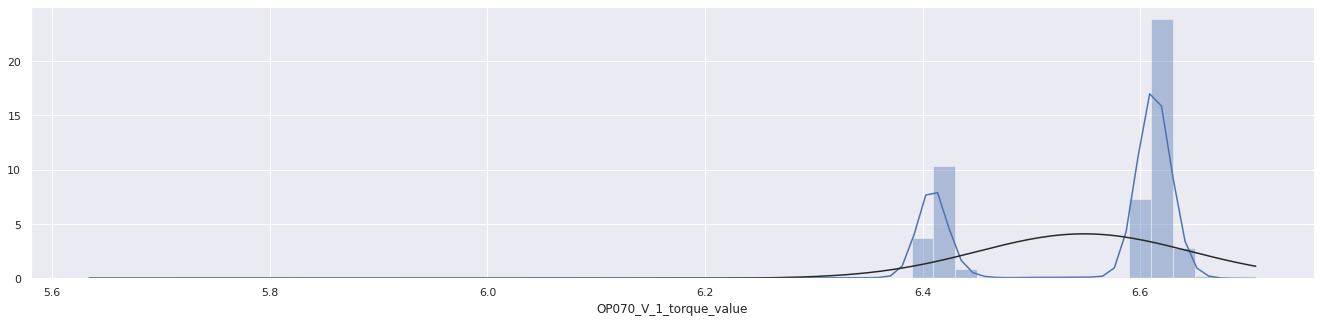

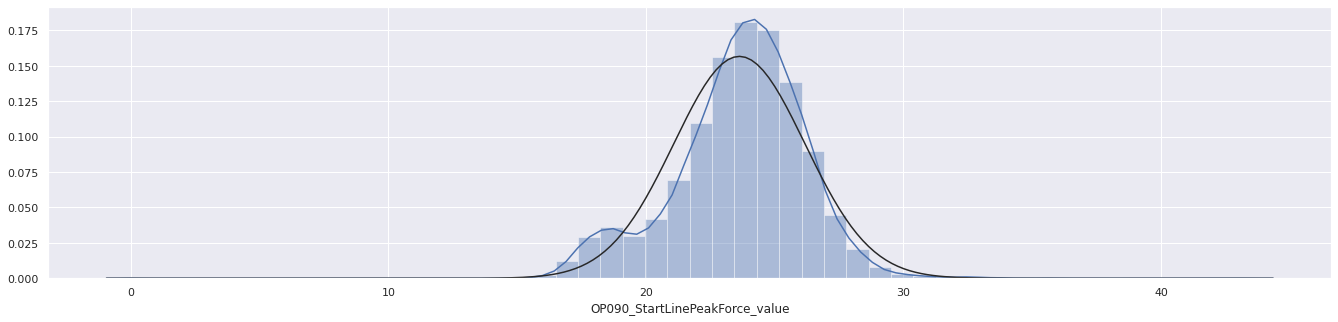

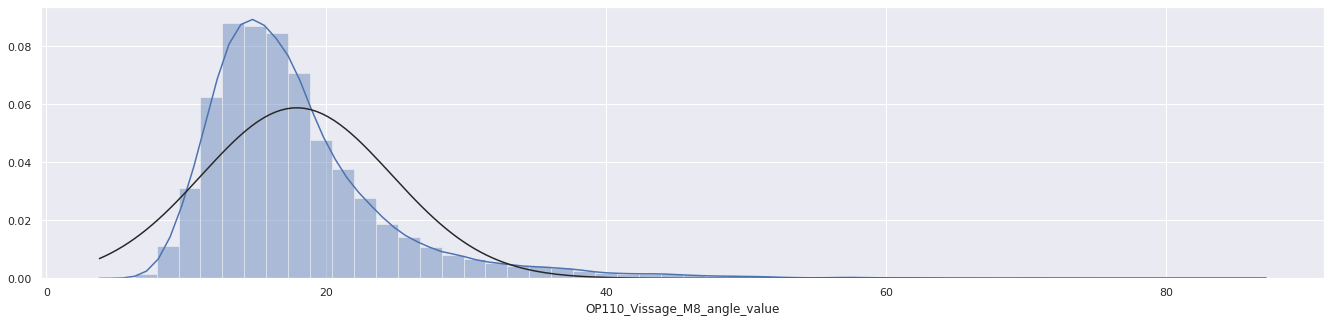

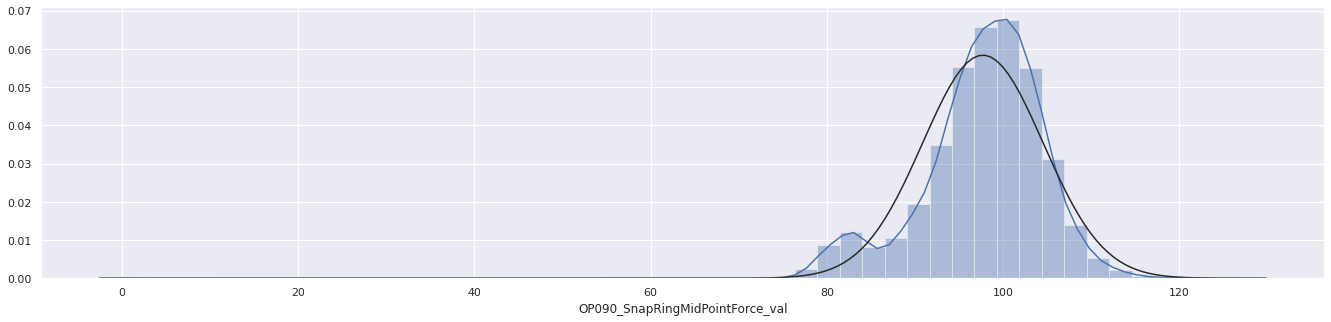

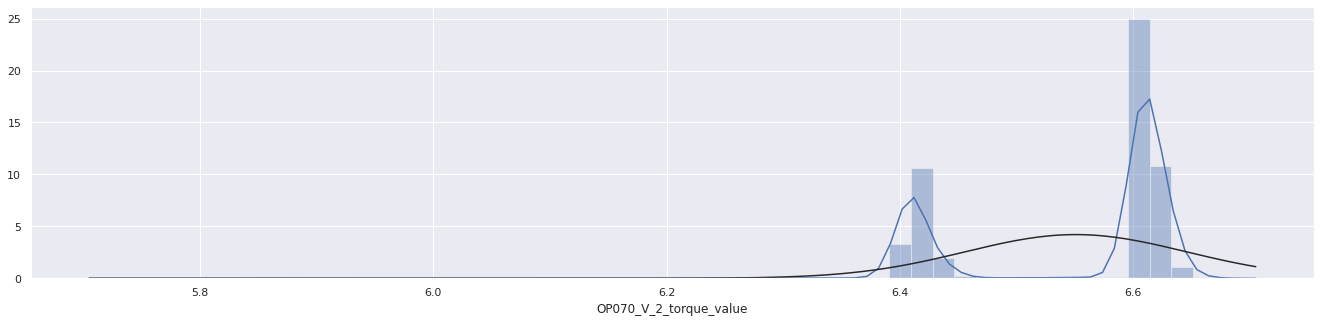

In [22]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(23,5));
    _ = sns.distplot(trainset[col],fit=norm);

In [16]:
#number of distinct values per variable
trainset.nunique().sort_values()

Binar OP130_Resultat_Global_v          2
OP120_Rodage_U_mesure_value            3
OP100_Capuchon_insertion_mesure       19
OP110_Vissage_M8_torque_value         48
OP090_SnapRingFinalStroke_value       56
OP070_V_2_torque_value                64
OP070_V_1_torque_value                70
OP110_Vissage_M8_angle_value         522
OP070_V_1_angle_value                831
OP070_V_2_angle_value                840
OP090_StartLinePeakForce_value      1515
OP120_Rodage_I_mesure_value         2100
OP090_SnapRingMidPointForce_val     3580
OP090_SnapRingPeakForce_value       5194
PROC_TRACEINFO                     34515
dtype: int64

## Bivariate Analysis

### Variables / Target Relation: Histogram

In [25]:
ok_trainset = trainset[trainset[target]==0]
ko_trainset = trainset[trainset[target]==1]

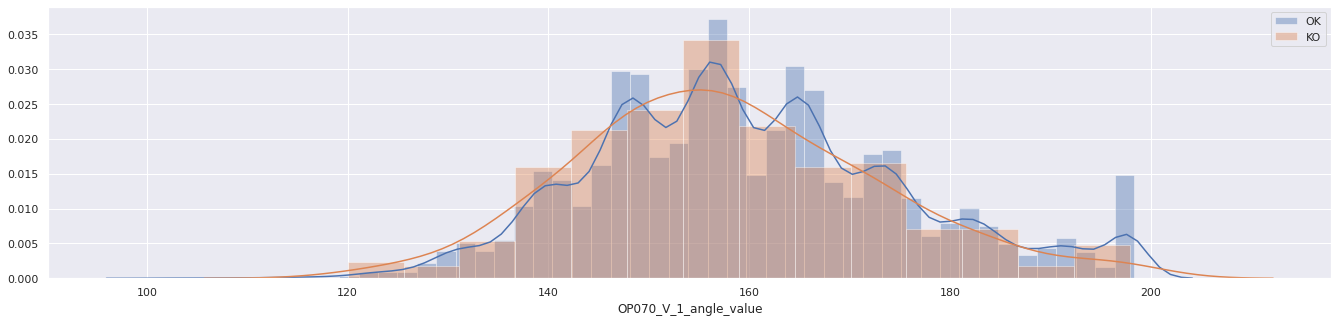

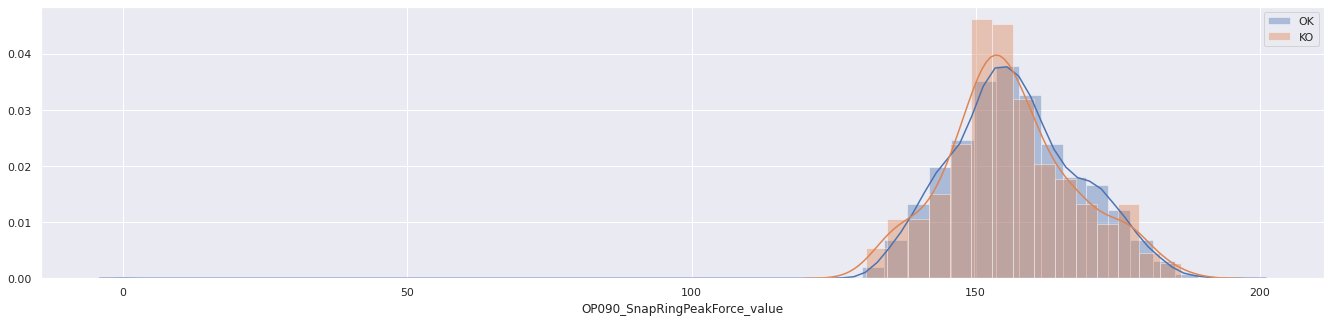

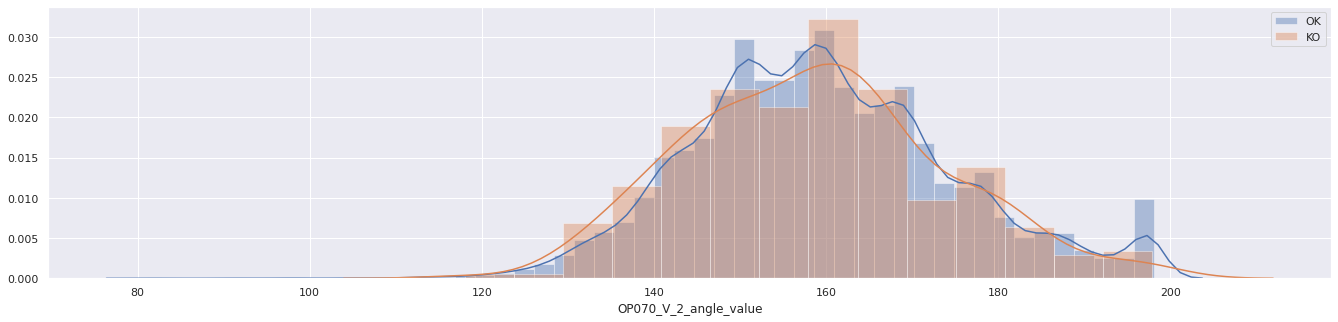

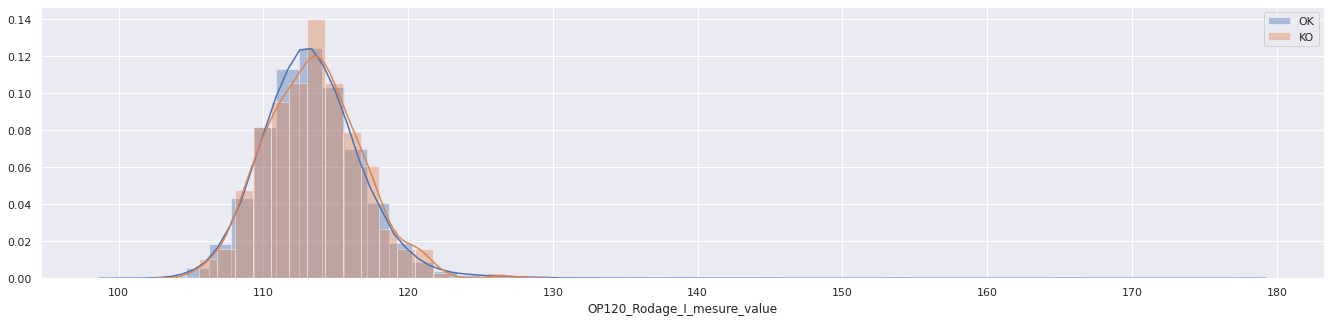

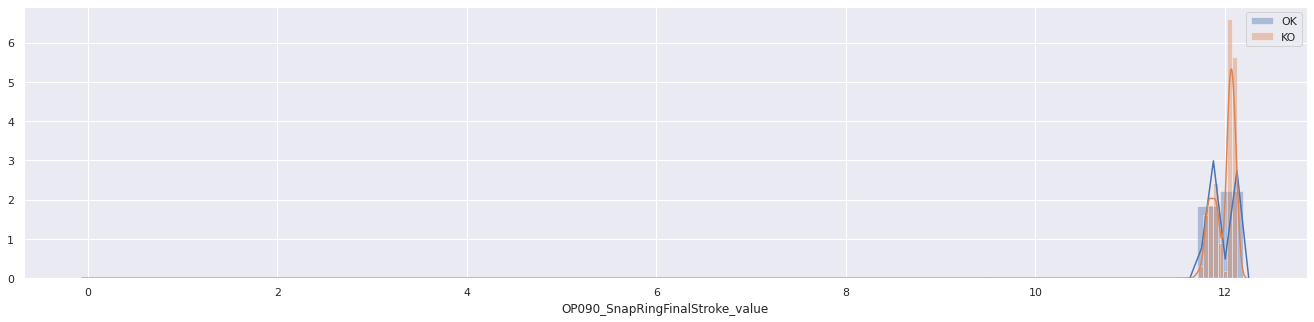

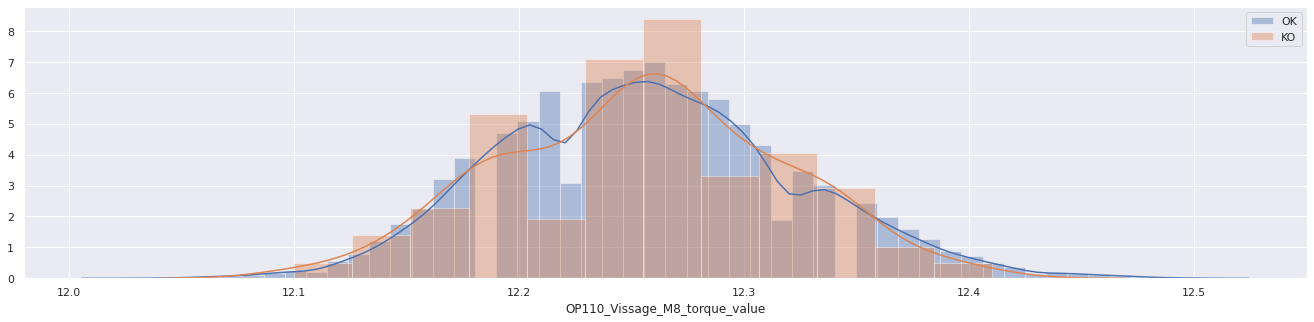

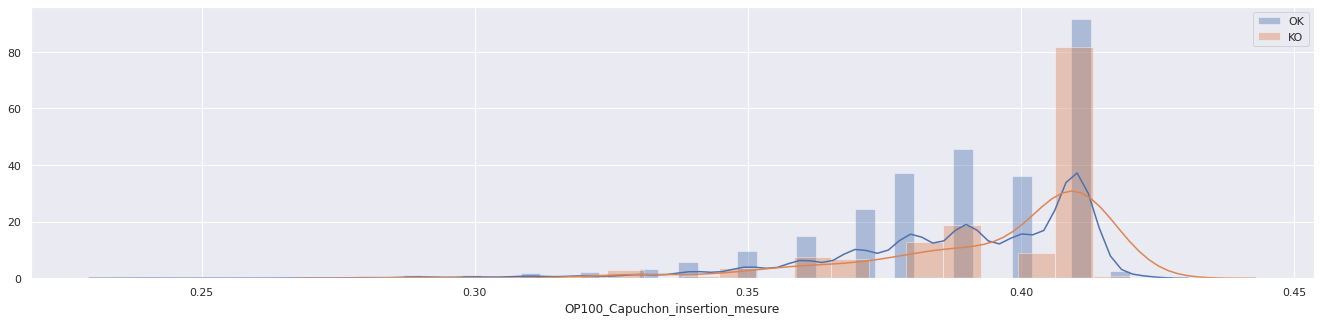

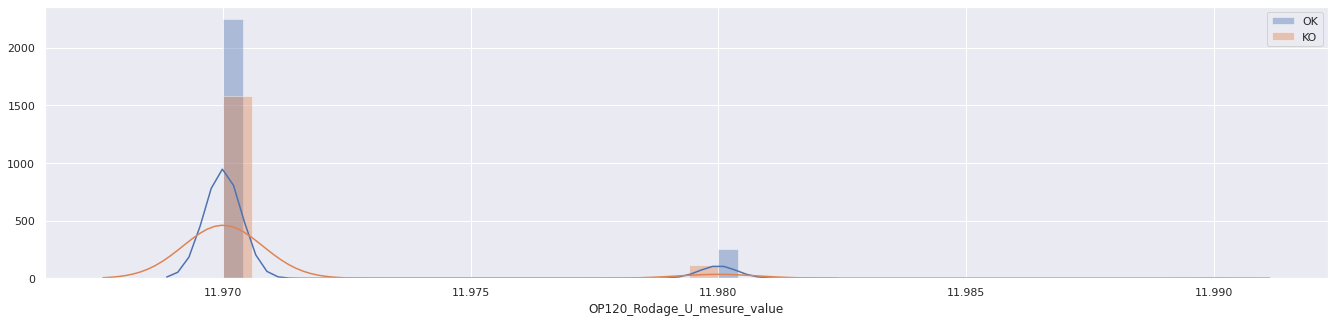

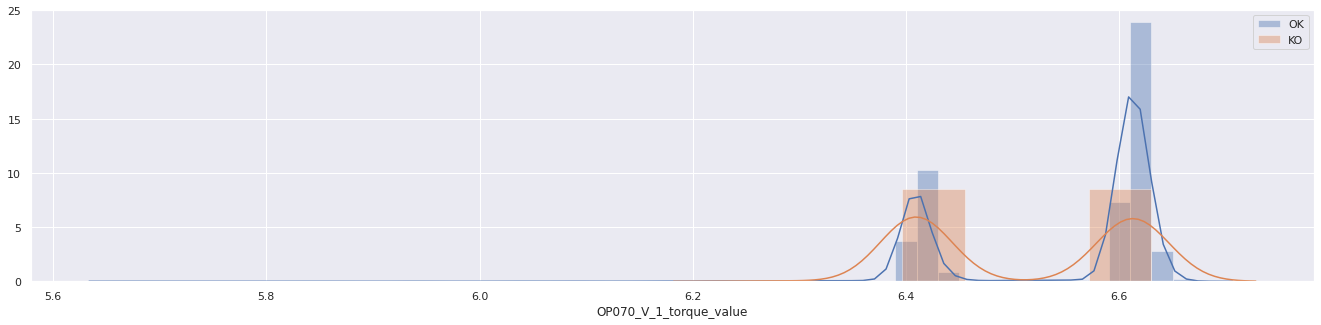

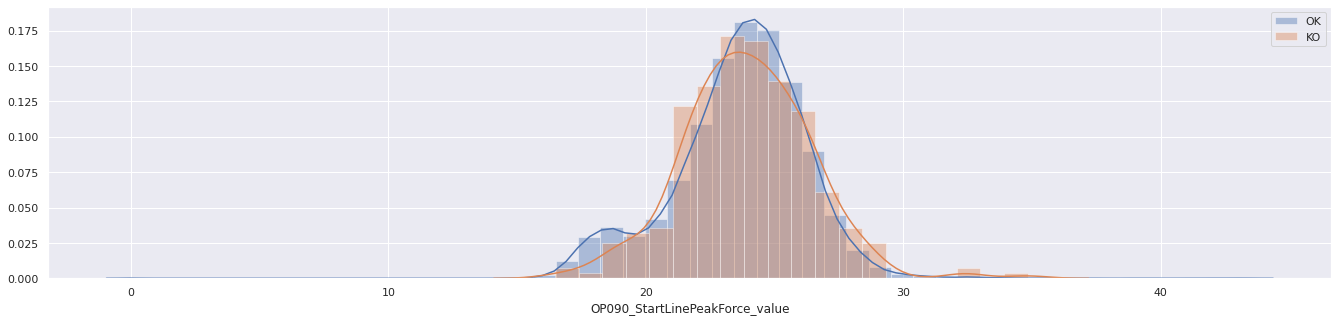

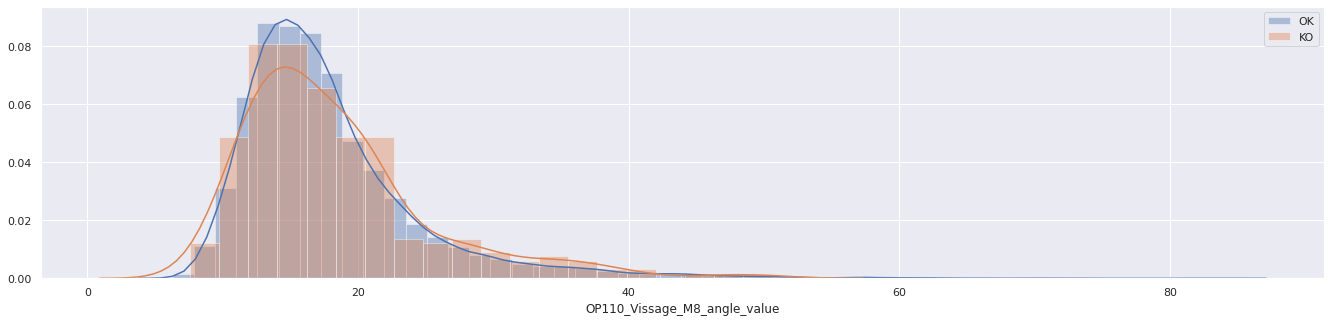

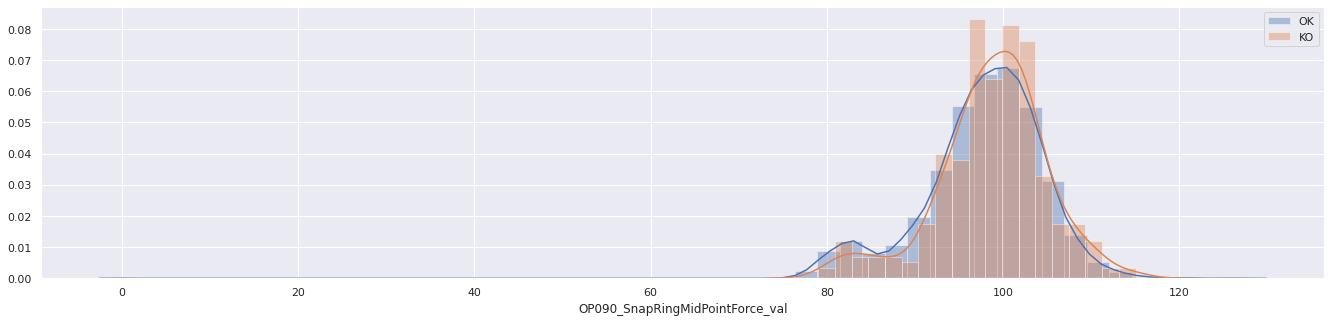

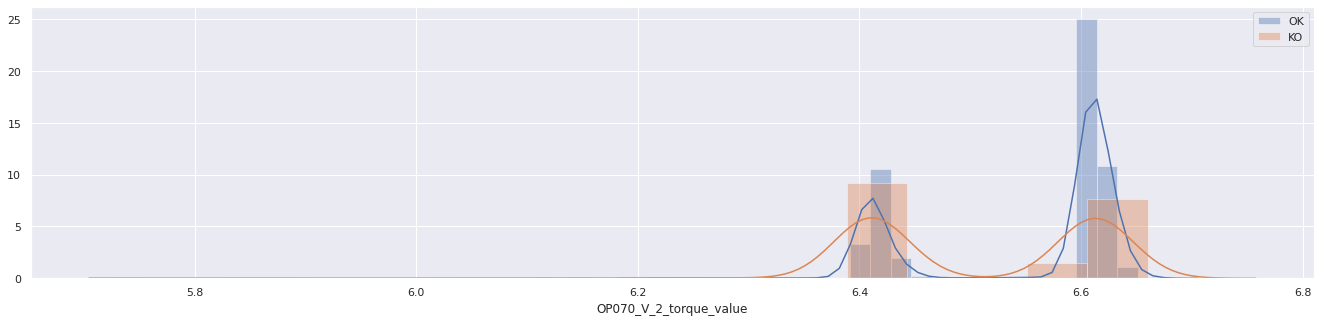

In [26]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(23,5));
    _ = sns.distplot(ok_trainset[col], label="OK")
    _ = sns.distplot(ko_trainset[col], label="KO")
    _ = plt.legend()

### Variables / Target Relation: Boxplot

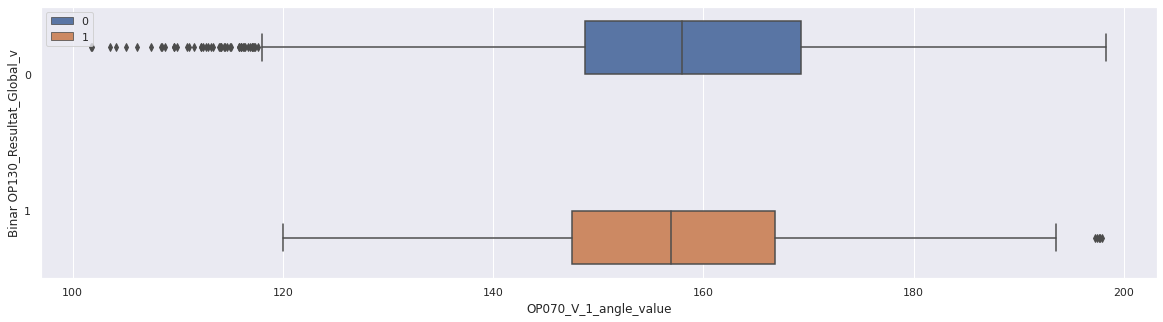

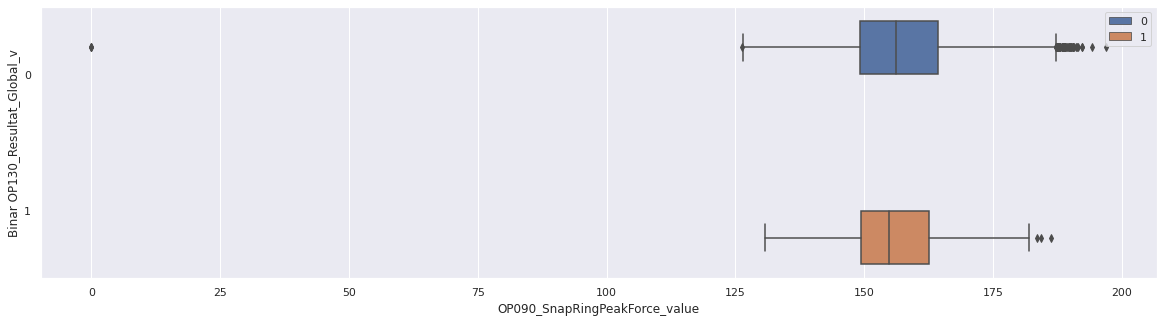

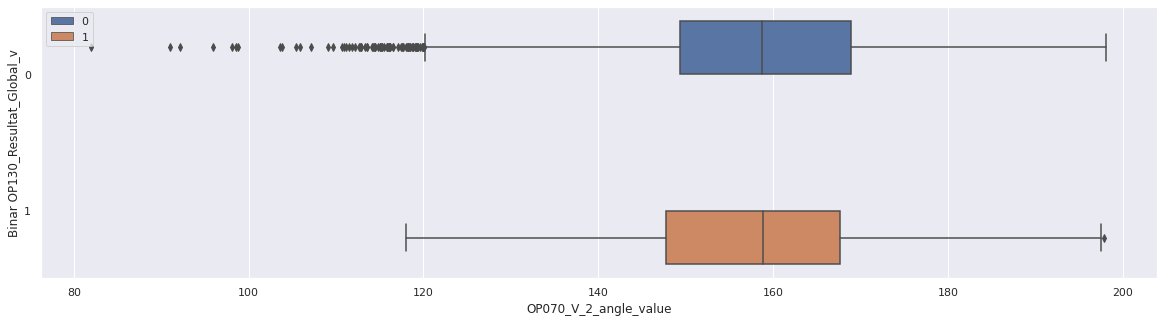

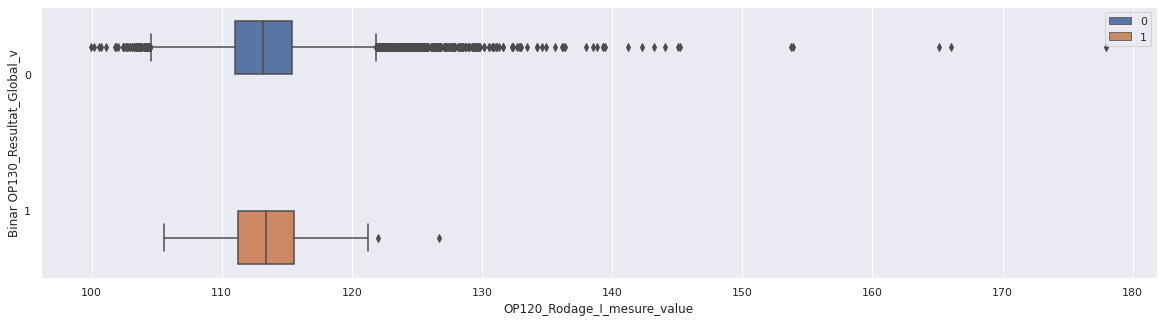

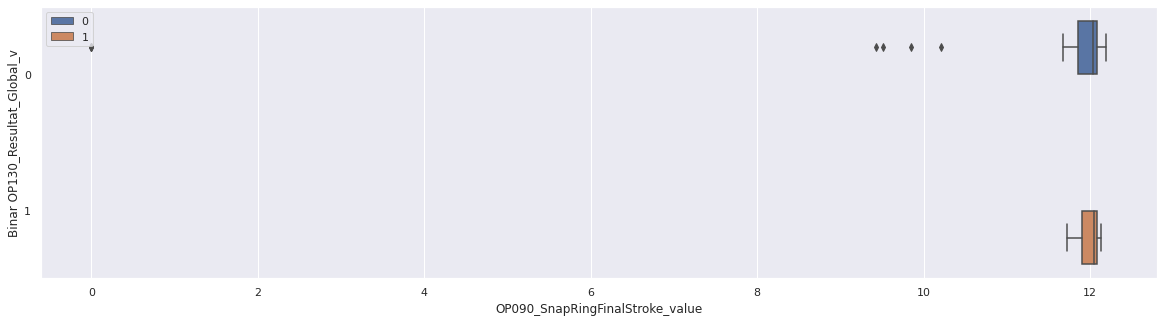

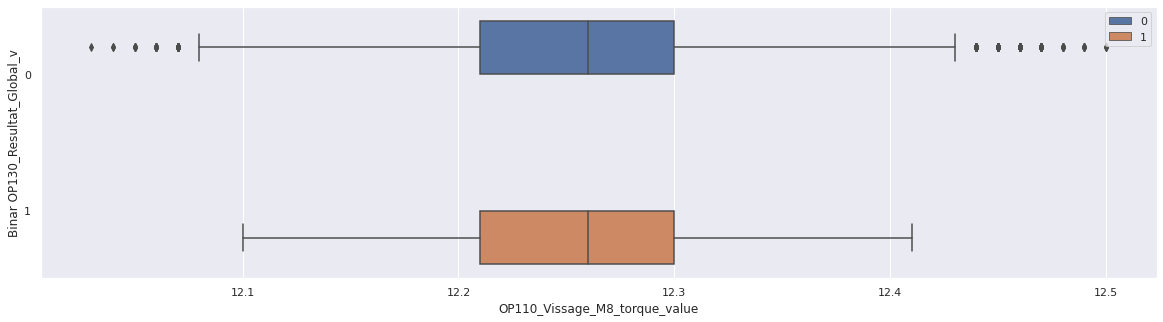

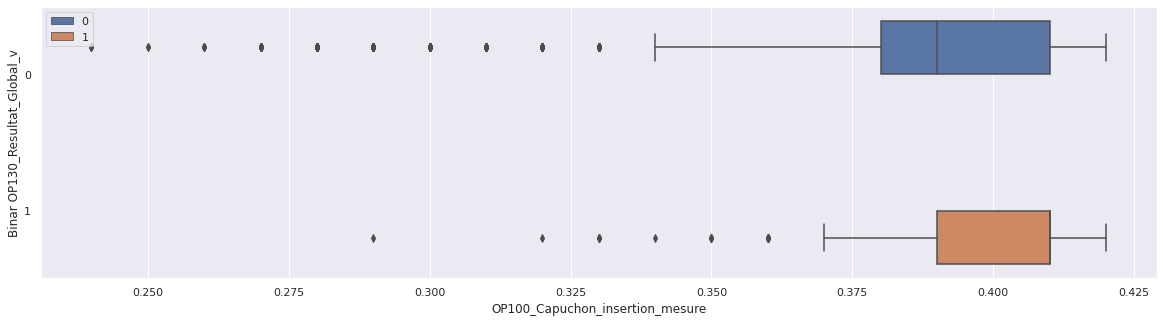

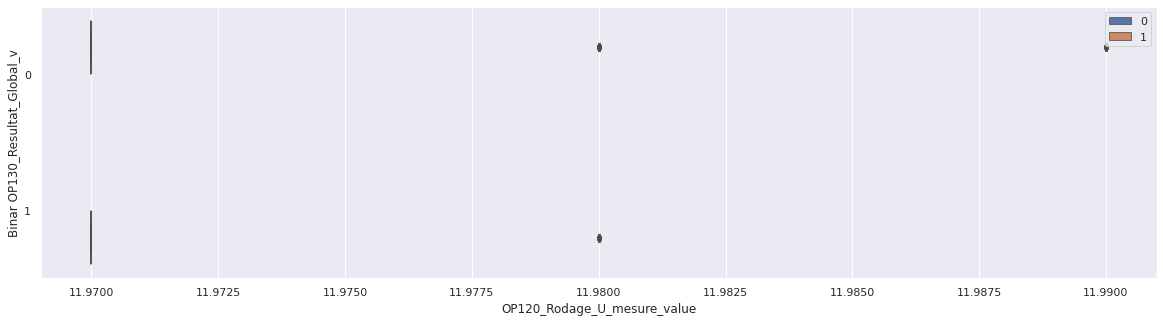

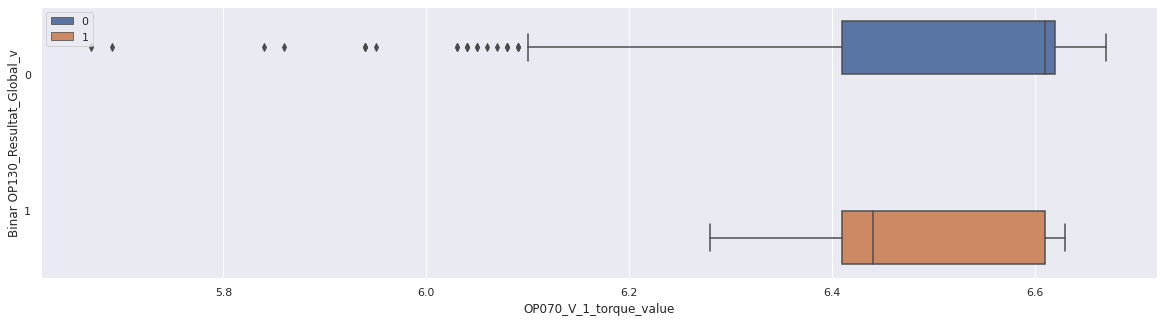

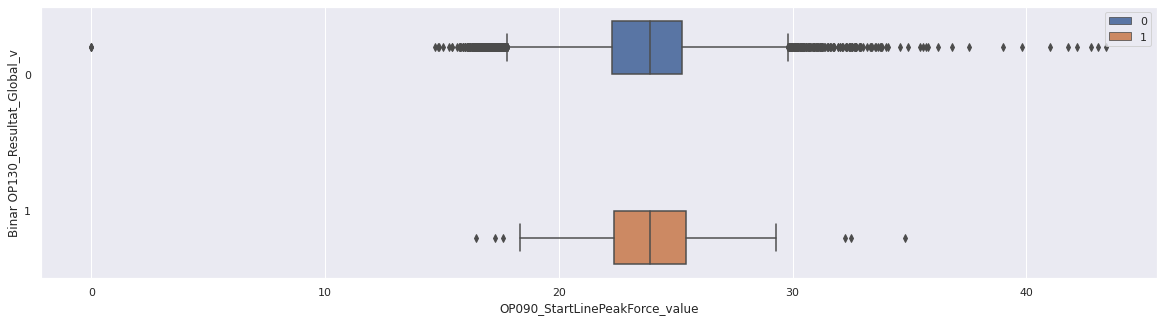

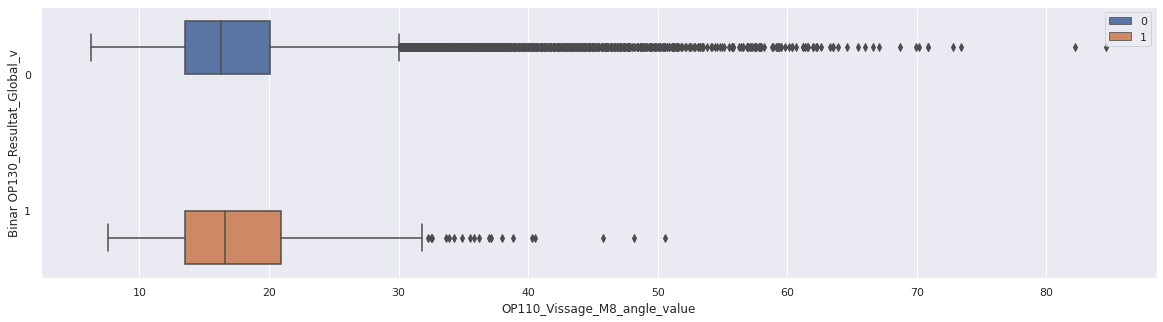

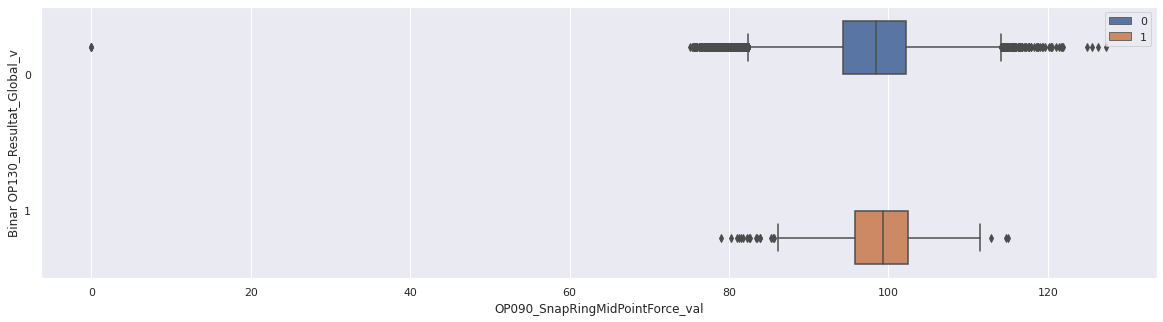

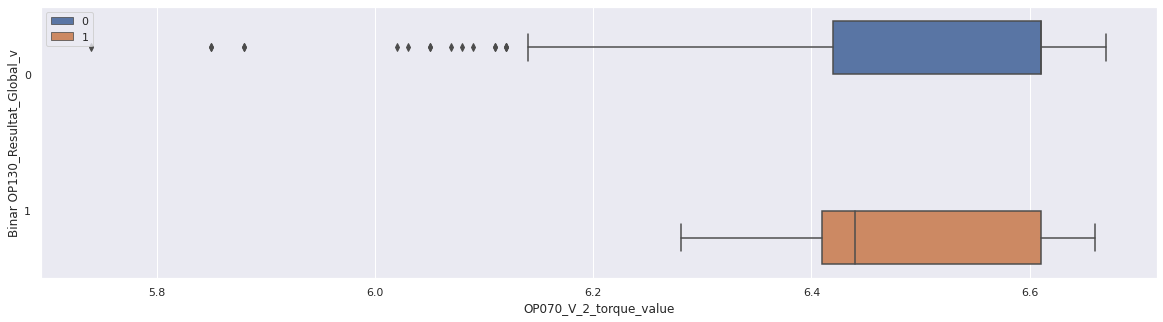

In [65]:
for col in trainset.select_dtypes("float"):
    _ = plt.figure(figsize=(20,5));
    _ = sns.boxplot(x=col, y=target, hue=target, data=trainset, orient="h")
    _ = plt.legend()

### Variables / Variables Relation

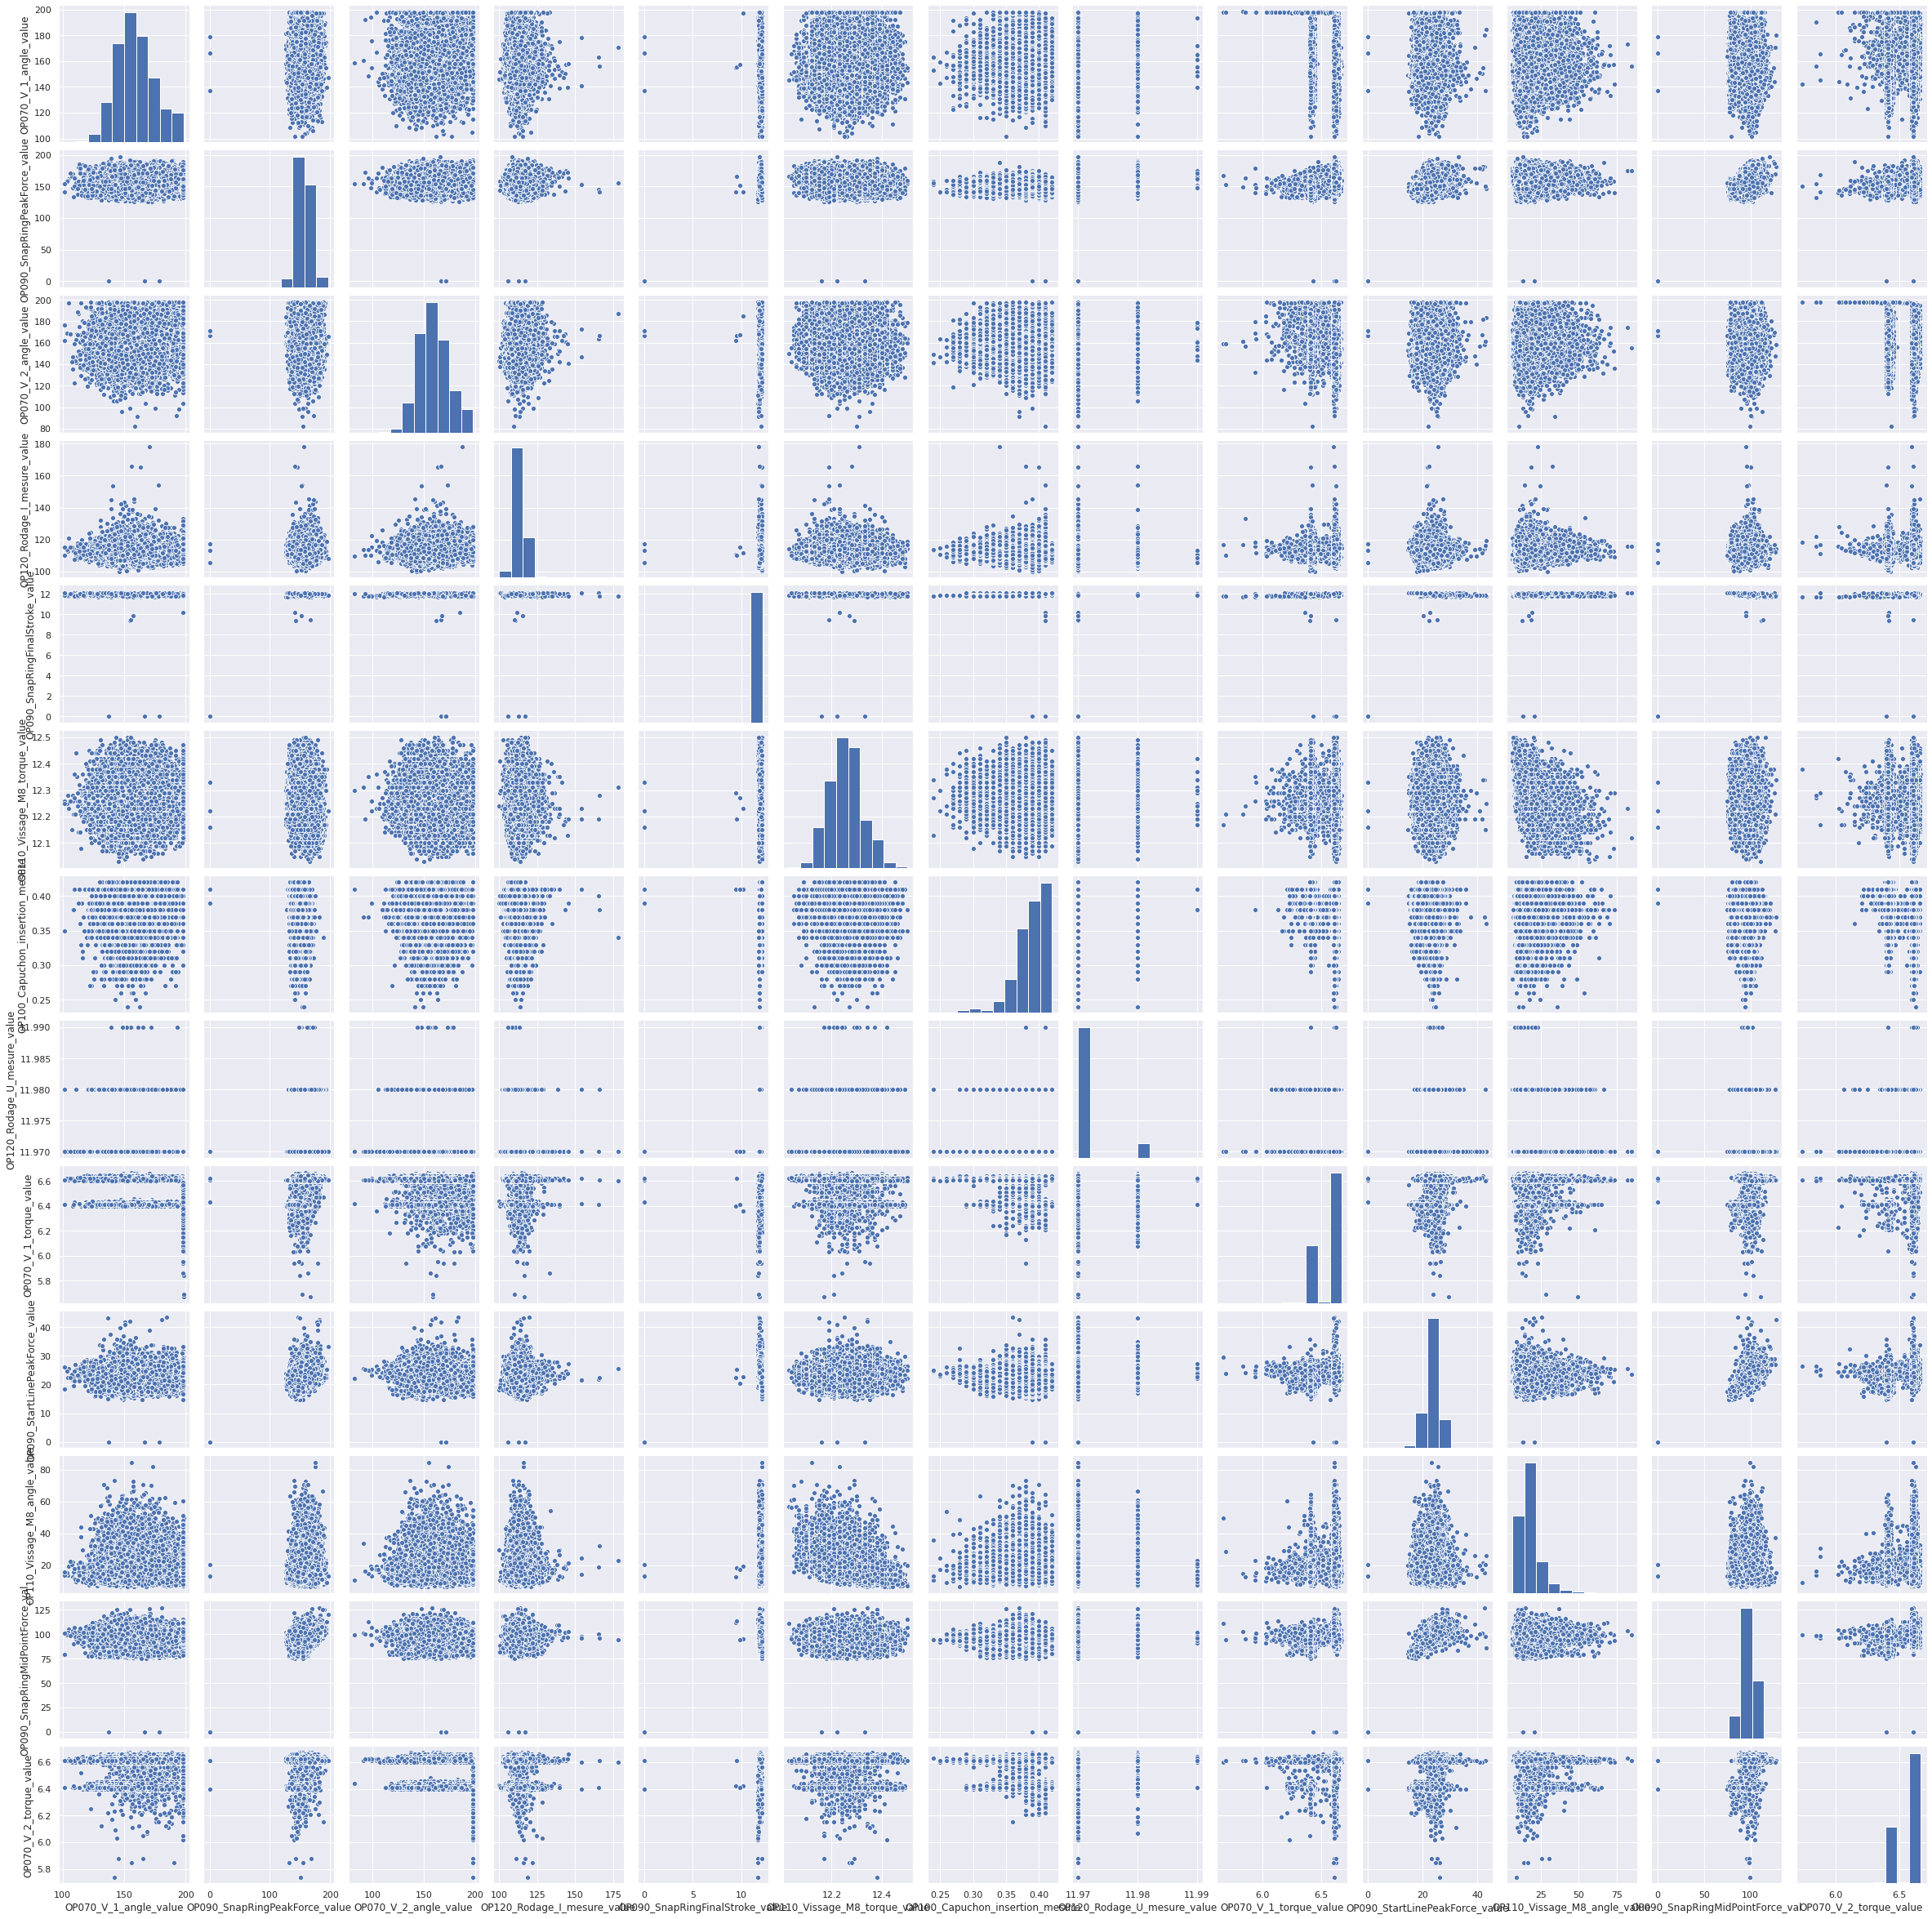

In [18]:
sns.pairplot(trainset.select_dtypes('float'))

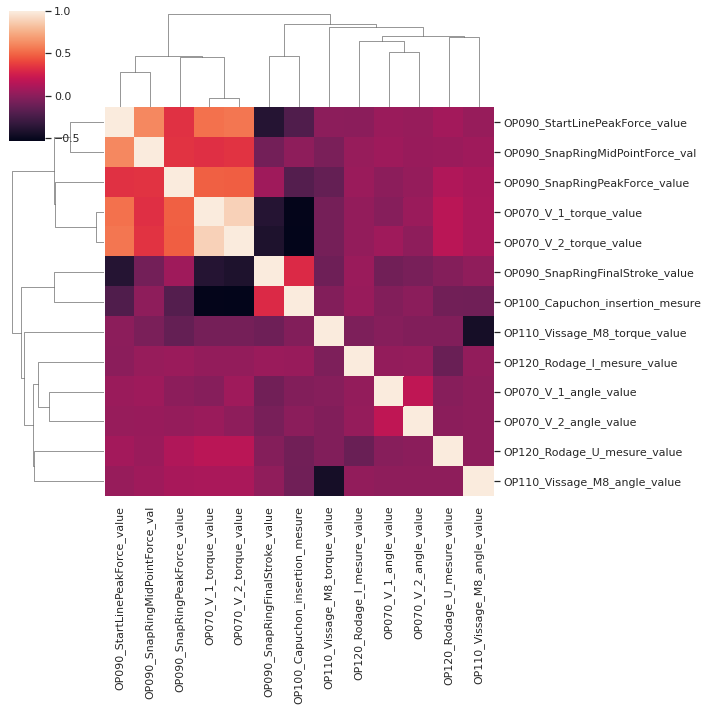

In [19]:
sns.clustermap(trainset.select_dtypes('float').corr())

## Hypothesis Tests